### Jade's Changes

<b>Current problems</b>:
- amp;
- div &gt; div.group &gt; p:first-child"&gt; = video cnbc
- no space between words separated by new line
- Check out the companies making headlines before the belldiv gt divgroup gt pfirstchildgt
- CNBC in general
- shit at the end: To contact... blah blah
- © CNBC is a USA TODAY content partner offering financial news and commentary. Its content is produced independently of USA TODAY.
- Read or Share this story:
- Read more here.
- FT subscribers can click here to receive Market Forces every day by email.
- Your feedback
- I'd love to hear from you. You can email me on michael.mackenzie@ft.com and follow me on Twitter at @michaellachlan.
- COPYRIGHT
- © 2019 Bloomberg L.P
- (Bloomberg)—
- Anything with "Transcript" should be removed
- Write to Sara Castellanos at sara.castellanos@wsj.com
- Disclosure: Cramer's charitable trust owns shares of Johnson &amp; Johnson.
- Questions for Cramer?Call Cramer: 1-800-743-CNBC
- Want to take a deep dive into Cramer's world? Hit him up!Mad Money Twitter - Jim Cramer Twitter - Facebook - Instagram
- Questions, comments, suggestions for the "Mad Money" website? madcap@cnbc.com
- RPT-

<b>Some rules I'm considering</b>:
- Rid articles with less than 5 periods
- Rid articles where writers say "I" a lot
- ~~Rid anything with Jim Cramer~~ done
- ~~Rid articles with title containing "transcript"~~ done
- ~~Rid articles with title containing "rpt" (repeat)~~ done

Within articles:
- Periods between 2 numbers should be preserved
- Remove any lines in articles that don't contain periods
- Remove any lines that don't have more than 5 words
- Remove sentences containing "more here"
- Remove anything after ©
- Remove any of the last 3 sentences if they contain "questions, comments" or "email" or "write to" or "I"

In [70]:
# imports
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import pandas as pd
import re, string

In [71]:
# Import articles
def importData(filename):
    """
    Import data into df
    """
    #Import Labelled Data
    DATA_DIR = "Data"
    thispath = Path().absolute()
    ARTICLES = os.path.join(DATA_DIR, filename)
    
    df = pd.read_excel(ARTICLES)

    try:
        df.head()
    except:
        pass
    return df

In [72]:
df = importData("newsApiOutput.xlsx")

In [73]:
#remove blanks (NaN)
df = df.dropna(subset = ['content', 'title']) 

#remove blocked articles without content
df = df[df.content.str.contains('Your usage has been flagged', case=False) == False]
df = df[df.content.str.contains('To continue, please click the box', case=False) == False]

#remove vidoes/ads/commentary
df = df[df.description.str.contains('The "Fast Money" traders share their first moves for the market open.', case=False) == False]
df = df[df.description.str.contains('stuff we think you', case=False) == False]

#remove transcripts
df = df[df.title.str.contains('transcript', case=False) == False]

#remove cramer
df = df[df.title.str.contains('cramer', case=False) == False]

#keep articles with more than 300 words, which is the lower end of the boxplot
df = df[df['content'].str.split().str.len() > 300]

#remove duplicates
# by self-identified repeat
df = df[df.title.str.contains('rpt', case=False) == False]
# by title
df = df.drop_duplicates(subset=['title'], keep='first')
# by content
df = df.drop_duplicates(subset=['content'], keep='first')
# by decription
df = df.drop_duplicates(subset=['description'], keep='first')

df = df.reset_index(drop=True)

# CLEAN ORIGINAL CONTENT
df['origContent'] = df['content'] 

#Remove nonsense sentences from original content pull
for i in df.index:
    
    article = df['origContent'].iloc[i].split('\r\n')
   
    # remove lines with no period
    article[:] = [sentence for sentence in article if '.' in sentence]
    # remove lines with less than 5 words
    article[:] = [sentence for sentence in article if len(sentence.split())>5]
    # remove photo credits
    article[:] = [sentence for sentence in article if not('Photo' in sentence)]
    blackList = ['get breaking news','click here','write to','subscribe','read more','read or share','reporting by','twitter, instagram','comment','copyright','©']
    # remove lines with terms that are associated with useless sentences
    article[:] = [sentence for sentence in article if not any(term in sentence.lower() for term in blackList)]

    df.at[i,'origContent']='\r\n'.join(article)

#Remove videos from cnbc links
pat_cnbcVid = re.compile('div &gt; div\.group &gt; p:first-child"&gt;')
df['origContent'] = list(map(lambda x: pat_cnbcVid.sub('', x), df['origContent']))
#Remove amp;
pat_amp = re.compile('amp;')
df['origContent'] = list(map(lambda x: pat_amp.sub('', x), df['origContent']))

# CLEAN CONTENT FOR FEATURE SELECTION df['content'] AND CONTEXT EXTRACTION df['contentWithStops'] 

#Remove time
pat_time = re.compile('[0-9]{0,2}:?[0-9]{1,2}\s?[aApP]\.?[mM]\.?')
df['content'] = list(map(lambda x: pat_time.sub(' ', x), df['origContent'].str.lower()))

#Remove urls
pat_url = re.compile('[a-z]+?[.]?[a-z]+?[.]?[a-z]+[.]?[\/\/]\S+')
df['content'] = list(map(lambda x: pat_url.sub('URL', x), df['content']))
pat_https = re.compile('https://')
df['content'] = list(map(lambda x: pat_https.sub('', x), df['content']))

#Remove stopwords
stopwords = [
    # dates/times
    "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december", "jan", "feb","mar", "apr", "jun", "jul", "aug", "oct", "nov", "dec", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "morning", "evening","today","pm","am",
    # symbols that don't separate a sentence
    '$','“','”','’','—', '-',
    # specific article terms that are useless
    "read", "share", "file", "'s", "photo", "inc", "corp", "group", "inc", "corp", "source", "bloomberg", "cnbc","cnbcs", "cnn", "reuters","bbc", "published", "broadcast","york","msnbc","ap","said",
    # other useless terms
    "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "co", "inc", "com", "theyve", "theyre", "theres", "heres", "didnt", "wouldn", "couldn", "didn","nbcuniversal","according", "just", "us", "ll", "times","yes","such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "just", "don", "now", "will", "wasn", "etc", "but", "hello", "welcome", "re","my",     
    # etc
    "also","us","the", "a", "of", "have", "has", "had", "having", "hello", "welcome", "yeah", "wasn", "today", "etc", "ext","definitely", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "while", "of", "at", "by", "for", "about", "into", "through", "during", "before", "after", "to", "from", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "just", "don", "now", "will"
]
pat_stopwords = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
df['content'] = list(map(lambda x: pat_stopwords.sub(' ', x), df['content'].str.lower()))

#Remove single character words
pat_charLim = re.compile('\s[a-zA-Z]\s')
df['content'] = list(map(lambda x: pat_charLim.sub(' ', x), df['content']))

#Remove characters that don't separate a sentence or aren't $ signs
# FOR context extraction
pat_nonStops = re.compile('[^\.\?!,;\$0-9a-zA-Z]+')
df['contentWithStops'] = list(map(lambda x: pat_nonStops.sub(' ', x), df['content']))

#Remove punctuation 
# FOR feature selection/encoding
pat_punctuation = re.compile('[^a-zA-Z]+')
df['content'] = list(map(lambda x: pat_punctuation.sub(' ', x), df['content']))

#Remove single characters
df['content'] = list(map(lambda x: pat_charLim.sub(' ', x), df['content']))

In [75]:
df['origContent'].iloc[4]

'Amazon has shown that it is "antithetical" to New York values, and the company should not be allowed to build its second headquarters in Queens until it changes its ways, City Councilman Jimmy Van Bramer told CNBC on Monday.\r\nBramer, deputy leader of the 51-member council, said one reason he is against the HQ2 deal is because of the online shopping behemoth\'s stance on labor unions.\r\n"They remarkably came to the City Council last week and declared not only would they not remain neutral when it came to efforts of their employees ... to organize but that they would actually fight to crush any effort of their employees to unionize," the Queens borough representative said on "Squawk on the Street." "This is a union town. I grew up in a union family. We\'ve got to stand up for our values there."\r\nBramer, a Democrat, also called out Amazon\'s reported ties to federal Immigration and Customs Enforcement agency.\r\nSome Amazon shareholders have urged the tech giant to stop selling Reko

In [76]:
df['content'].iloc[4]

'amazon shown antithetical new values company should allowed build second headquarters queens until changes ways city councilman jimmy van bramer told bramer deputy leader member council one reason against hq deal online shopping behemoth stance labor unions remarkably came city council last week declared would remain neutral came efforts employees organize would actually fight crush effort employees unionize queens borough representative squawk street union town grew up union family ve got stand up values bramer democrat called amazon reported ties federal immigration customs enforcement agency amazon shareholders urged tech giant stop selling rekognition facial recognition technology government agencies amazon planning pitch service ice obviously sanctuary city mayor declared want safe haven immigrants including undocumented bramer amazon refuses budge issue company defended selling rekognition law enforcement bramer believes gov andrew cuomo mayor bill de blasio democrats botched de

In [77]:
df['contentWithStops'].iloc[4]

'amazon shown antithetical new values, company should allowed build second headquarters queens until changes ways, city councilman jimmy van bramer told . bramer, deputy leader 51 member council, one reason against hq2 deal online shopping behemoth stance labor unions. remarkably came city council last week declared would remain neutral came efforts employees ... organize would actually fight crush effort employees unionize, queens borough representative squawk street. union town. grew up union family. ve got stand up values . bramer, democrat, called amazon reported ties federal immigration customs enforcement agency. amazon shareholders urged tech giant stop selling rekognition, facial recognition technology, government agencies. amazon planning pitch service ice. obviously sanctuary city. mayor declared want safe haven immigrants, including undocumented, bramer . amazon refuses budge issue. company defended selling rekognition law enforcement. bramer believes gov. andrew cuomo mayor

In [78]:
df = df[df['content'].str.split().str.len() > 500]

AttributeError: 'AxesSubplot' object has no attribute 'show'

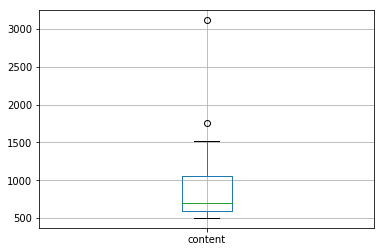

In [81]:
plot = df['content'].str.split().str.len().to_frame().boxplot()
plot.show

In [287]:
df['cleanedContent'].iloc[100]

'SAO PAULO (Reuters) - Brazilian environmental groups on Tuesday blasted President Jair Bolsonaro’s environment minister after he dismissed the murdered Amazon rain forest defender Chico Mendes as “irrelevant.”  “I don’t know Chico Mendes,” Environment Minister Ricardo Salles told journalists on an interview show late Monday night, when asked about the famous Brazilian rubber tapper, union leader and environmentalist who was murdered in 1988.  As environment minister, Salles oversees the Instituto Chico Mendes, which is named after the environmental advocate and oversees Brazil’s protected conservation areas.  Bolsonaro downplayed environmental concerns during his 2018 far-right presidential campaign, threatening to pull Brazil out of the Paris Agreement on climate change and advocating more mining and economic development in the Amazon rainforest.  Salles told interviewers on TV show Roda Viva that he hears contradictory accounts about Mendes’ life, saying environmentalists praise his

In [216]:
OUTPUT_DIR = os.path.join("Data", 'cleanedArticles_test.xlsx')
writer = pd.ExcelWriter(OUTPUT_DIR)
df.to_excel(writer,'Sheet1')
writer.save()

In [59]:
test = ["I I I I I", "I. I. I. I.", "I. I . I .I .I .I", "I . a dad , I s.djaf I. I. i","I . a dad , I sdjaf I I i"]


In [60]:
for line in test:
    print(i,line.split().count('I'))

0 5
0 0
0 2
0 2
0 4


In [69]:
#remove opinion pieces identified by number of times "I" was used
#keep articles with less than 5 "I's"
df = df[df['content'].str.split().str.split().count('I') < 5]

KeyError: 'Level I must be same as name (None)'